In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

# Forward Model

In [2]:
info = get_info(kind='biosemi32')
fwd = create_forward_model(info=info, sampling='ico3')
adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()
leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


# Simulation

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 19.01it/s]

Using control points [0.00000000e+00 0.00000000e+00 1.28113534e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


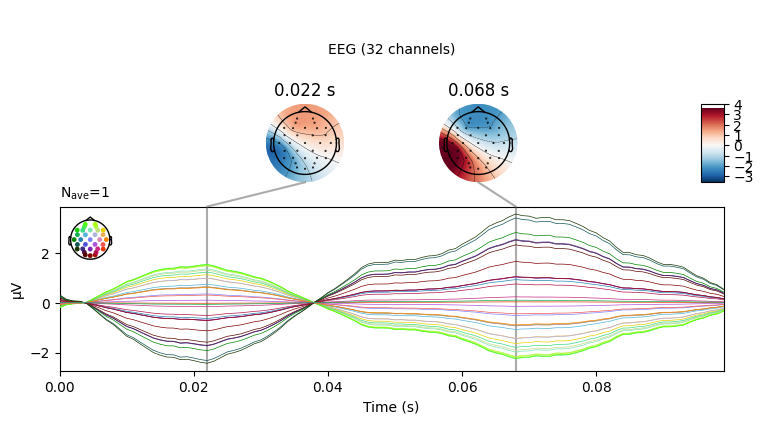

In [110]:
%matplotlib qt
# settings = dict(number_of_sources=5, extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)
settings = dict(number_of_sources=1, extents=1, duration_of_trial=0.1, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Defs

In [5]:
def soft_thresholding(r, lam):
    r = np.squeeze(np.array(r))
    C = np.sign(r) * np.clip(abs(r) - lam, a_min=0, a_max=None)
    return C

def zero_norm(x):
    return (x!=0).sum()

adjacency_non_diag = deepcopy(adjacency)
np.fill_diagonal(adjacency_non_diag, 0)
neigh_idc = [np.where(ad)[0] for ad in adjacency_non_diag]

def smoothness_l1(x, adjacency, lam_smooth=0.1):
    amplitudes_of_neighbors = get_amplitudes_of_neighbors(x, adjacency)
    term = np.sum( abs(x) - (amplitudes_of_neighbors * lam_smooth) )
    # print(abs(x).sum(), (amplitudes_of_neighbors * lam_smooth).sum())
    return term
def get_l1(x):
    return np.sum( abs(x) )

def get_amplitudes_of_neighbors(x, neigh_idc):
    # x_adj = (x[:, np.newaxis] @ x[np.newaxis, :] )* adjacency
    # np.fill_diagonal(x_adj, 0)
    # amplitudes_of_neighbors = np.sum(abs(x_adj), axis=0)
    amplitudes_of_neighbors = [np.mean(abs(x[idc])) for idc in neigh_idc]
    return np.array(amplitudes_of_neighbors)

def get_gradient_of_neighbors(x, neigh_idc):
    amplitudes_of_neighbors = [np.mean(abs(x[idc])) for idc in neigh_idc]
    return (abs(x).T - np.array(amplitudes_of_neighbors)**2).T

def temporal_smoothness(x):
    smoothness = np.diff(x, axis=1, prepend=0)
    smoothness[:, 0] = -smoothness[:, 1]
    return smoothness

# ISTA

In [ ]:
t_total = int(1e5)
A = deepcopy(leadfield)

n_chans, n_dipoles = A.shape
beta = 1 / np.sum(A**2)
lam = 1e-14
x_t = np.zeros(n_dipoles)
errors = []
A_H = np.matrix(A).getH()
# for t in range(t_total):
t = 0
while True:
    v_t = y - A @ x_t
    errors.append( np.linalg.norm(v_t) )
    if np.mod(t, 1000) == 0:
        print(f"iter {t} error {errors[-1]} maxval {abs(x_t).max()}")
    r = x_t + beta * A_H @ v_t
    x_tp = soft_thresholding(r, lam)
    if np.any(np.isnan(x_tp)):# or (t > 1 and errors [-1] > errors[-2]):
        break
    x_t = x_tp
    t += 1

## Evaluate

In [ ]:
stc_ = stc.copy()
stc_.data[:, 0] = x_t / abs(x_t).max()
stc_.plot(**pp)

# FISTA

In [26]:
t_total = int(1e5)
A = deepcopy(leadfield)
n_chans, n_dipoles = A.shape
beta = 1 / np.sum(A**2)
lam = 1e-12
patience = 1000
x_t = np.zeros(n_dipoles)
x_t_prev = np.zeros(n_dipoles)
x_best = np.zeros(n_dipoles)
error_best = np.inf
t_best = 0
errors = []
A_H = np.matrix(A).getH()
for t in range(t_total):
# t = 0
# while True:
    v_t = y - A @ x_t
    
    r = x_t + beta * A_H @ v_t + ((t-2)/(t+1)) * (x_t - x_t_prev)
    x_tplus = soft_thresholding(r, lam)
    
    x_t_prev = deepcopy(x_t)
    x_t = x_tplus
    error = np.sum((y - A @ x_t)**2) * 0.5 + lam * abs(x_t).sum()
    errors.append( error )

    if error < error_best:
        x_best = deepcopy(x_t)
        error_best = error
        t_best = t
    if t>patience and  (np.any(np.isnan(x_tplus))  or np.all(np.array(errors[-patience:-1]) < errors[-1] )):
        break
    if np.mod(t, 1000) == 0:
        print(f"iter {t} error {errors[-1]} maxval {abs(x_t).max()}")

print(f"Finished after {t_best} iterations, error = {error_best}")
print("Neighbor Term: ", np.sum(get_gradient_of_neighbors(x_t, adjacency)*np.sign(x_t))*1e-5, "L1 Term: ", np.mean(abs(x_best)))

iter 0 error 2.58019362663294e-10 maxval 0.0
iter 1000 error 2.58019362663294e-10 maxval 0.0
iter 2000 error 2.58019362663294e-10 maxval 0.0
iter 3000 error 2.58019362663294e-10 maxval 0.0
iter 4000 error 2.58019362663294e-10 maxval 0.0
iter 5000 error 2.58019362663294e-10 maxval 0.0
iter 6000 error 2.58019362663294e-10 maxval 0.0
iter 7000 error 2.58019362663294e-10 maxval 0.0
iter 8000 error 2.58019362663294e-10 maxval 0.0
iter 9000 error 2.58019362663294e-10 maxval 0.0
iter 10000 error 2.58019362663294e-10 maxval 0.0
iter 11000 error 2.58019362663294e-10 maxval 0.0
iter 12000 error 2.58019362663294e-10 maxval 0.0
iter 13000 error 2.58019362663294e-10 maxval 0.0
iter 14000 error 2.58019362663294e-10 maxval 0.0
iter 15000 error 2.58019362663294e-10 maxval 0.0
iter 16000 error 2.58019362663294e-10 maxval 0.0
iter 17000 error 2.58019362663294e-10 maxval 0.0
iter 18000 error 2.58019362663294e-10 maxval 0.0
iter 19000 error 2.58019362663294e-10 maxval 0.0
iter 20000 error 2.58019362663294

## Evaluate

In [27]:
stc_ = stc.copy()
stc_.data[:, 0] = x_best / abs(x_best).max()
stc_.plot(**pp, brain_kwargs=dict(title="FISTA"))

Using control points [nan nan nan]


C:\Users\Lukas\AppData\Local\Temp\ipykernel_11568\2162874220.py:2: RuntimeWarning: invalid value encountered in divide
  stc_.data[:, 0] = x_best / abs(x_best).max()


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


AssertionError: 

# st-Fista

In [35]:
t = np.arange(1000)
y = ((t-2)/(t+1))
plt.figure()
plt.loglog(t, y)

In [39]:
(A_H@v_t).shape

(1284, 100)

In [45]:
t_total = int(1e5)
y = evoked.data
x = stc.data
n_time = x.shape[1]
A = deepcopy(leadfield)
n_chans, n_dipoles = A.shape
beta = 1 / np.sum(A**2)

lam = 1e-24

lam_l1 = 1
lam_ts = 1e-8
lam_gradient = 1e-17

patience = 1000
x_t = np.zeros((n_dipoles, n_time))
x_t_prev = np.zeros((n_dipoles, n_time))
x_best = np.zeros(n_dipoles)
error_best = np.inf
errors = []
errors_l1 = []
errors_st = []
errors_gradient = []
A_H = np.matrix(A).getH()
for t in range(t_total):
    v_t = y - A @ x_t
    # x_ts = temporal_smoothness(x_t)
    # x_grad = get_gradient_of_neighbors(x_t, adjacency)
    # r = lam_l1 * x_t + beta * A_H @ v_t + ((t-2)/(t+1)) * (x_t - x_t_prev) #+ lam_ts * x_ts + lam_gradient * x_grad
    
    r = x_t + beta * A_H @ v_t + ((t-2)/(t+1)) * (x_t - x_t_prev)
    x_tplus = soft_thresholding(r, lam)
    
    x_t_prev = deepcopy(x_t)
    x_t = x_tplus
    error_l1 =  abs(x_t).mean()
    error = error_l1
    errors.append( error )

    # error_st = lam_ts * x_ts.sum()
    # error_gradient = lam_gradient * x_grad.sum()
    # error_meas = np.sum((y - A @ x_t)**2) * 0.5
    # error = error_meas + error_l1 + error_st + error_gradient
    # print(error_meas, error_l1, error_st, error_gradient)
    # errors.append( error )
    # errors_l1.append( error_l1 )
    # errors_st.append( error_st )
    # errors_gradient.append( error_gradient )
    
    if error < error_best:
        x_best = deepcopy(x_t)
        error_best = error
    if t>patience and  (np.any(np.isnan(x_tplus))  or np.all(np.array(errors[-patience:-1]) < errors[-1] )):
        break
    if np.mod(t, 100) == 0:
        print(f"iter {t} error {errors[-1]} maxval {abs(x_t).max()}")

print(f"Finished after {t} iterations, error = {error_best}")
# print("Neighbor Term: ", np.sum(get_gradient_of_neighbors(x_t, adjacency)*np.sign(x_t))*1e-5, "L1 Term: ", np.sum(x_best))

iter 0 error 4.2137238952414986e-11 maxval 2.742932526734387e-10
iter 100 error 4.05218831573663e-10 maxval 1.9431865491270995e-08
iter 200 error 4.315469293263411e-10 maxval 2.348626180636327e-08
iter 300 error 4.3456568920324207e-10 maxval 2.4154260084643218e-08
iter 400 error 4.2998373712880694e-10 maxval 2.3869238526812046e-08
iter 500 error 4.2255202650046166e-10 maxval 2.3409897510416885e-08
iter 600 error 4.250463139659434e-10 maxval 2.365976457313728e-08
iter 700 error 4.2963389212870707e-10 maxval 2.3916086326677753e-08
iter 800 error 4.263950153443937e-10 maxval 2.370946074867578e-08
iter 900 error 4.243003559153891e-10 maxval 2.3563574406623035e-08
iter 1000 error 4.263637977825403e-10 maxval 2.3715233395468065e-08
iter 1100 error 4.27226618647825e-10 maxval 2.3775799450631947e-08
iter 1200 error 4.266536974615913e-10 maxval 2.3721872395984827e-08
iter 1300 error 4.249871904650137e-10 maxval 2.3629441733979242e-08
iter 1400 error 4.2638317703687943e-10 maxval 2.3726426254915

## Evaluate

In [46]:
%matplotlib qt
# plt.figure()
# plt.loglog(errors, label="errors")
# plt.loglog(errors_l1, label="errors_l1")
# plt.loglog(errors_st, label="errors_st")
# plt.loglog(errors_gradient, label="errors_gradient")
# plt.legend()

stc_ = stc.copy()
stc_.data = x_best / abs(x_best).max()
stc_.plot(**pp, brain_kwargs=dict(title="st-FISTA"))

Using control points [0.43003469 0.46888114 0.77806006]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.13251603 0.14800089 0.23262017]


# S-Fista

In [ ]:
t_total = int(1e5)
A = deepcopy(leadfield)
n_chans, n_dipoles = A.shape
beta = 1 / np.sum(A**2)
lam = 1e-14
patience = 10000
x_t = np.zeros(n_dipoles)
x_t_prev = np.zeros(n_dipoles)
x_best = np.zeros(n_dipoles)
lam_gradient = 1e-5
error_best = np.inf
errors = []
A_H = np.matrix(A).getH()
for t in range(t_total):
# t = 0
# while True:
    v_t = y - A @ x_t
    r = x_t + beta * A_H @ v_t + ((t-2)/(t+1)) * (x_t - x_t_prev) + get_gradient_of_neighbors(x_t, adjacency) * lam_gradient # * np.sign(x_t)
    
    x_tplus = soft_thresholding(r, lam)
    
    x_t_prev = deepcopy(x_t)
    x_t = x_tplus
     
    error = np.sum((y - A @ x_t)**2) * 0.5 + lam * abs(x_t).sum() + np.sum(get_gradient_of_neighbors(x_t, adjacency) * lam_gradient )  # * np.sign(x_t)
    errors.append( error )

    if errors[-1] < error_best:
        x_best = deepcopy(x_t)
        error_best = errors[-1]
    if t>patience and  (np.any(np.isnan(x_tplus))  or np.all(np.array(errors[-patience:-1]) < errors[-1] )):
        break
    if np.mod(t, 100) == 0:
        print(f"iter {t} error {errors[-1]} maxval {abs(x_t).max()}")

print(f"Finished after {t} iterations, error = {error_best}")
print("Neighbor Term: ", np.sum(get_gradient_of_neighbors(x_t, adjacency)*np.sign(x_t))*lam_gradient, "L1 Term: ", np.sum(x_best))

iter 0 error 2.7359715425398443e-10 maxval 1.0015689852552044e-10
iter 100 error 2.6099725186117462e-12 maxval 1.165446975323222e-09
iter 200 error 2.4767326912724186e-12 maxval 1.4973652289947094e-09
iter 300 error 2.330893687803134e-12 maxval 1.71461236223066e-09
iter 400 error 2.225570947298678e-12 maxval 1.9070616029349935e-09
iter 500 error 2.1307568375809016e-12 maxval 2.087351690679838e-09
iter 600 error 2.0688192522689617e-12 maxval 2.3427175759392686e-09
iter 700 error 2.0304930966354808e-12 maxval 2.6104566417851464e-09
iter 800 error 2.0126248441725004e-12 maxval 2.899000675890662e-09
iter 900 error 2.005232806930119e-12 maxval 3.1877998581756076e-09
iter 1000 error 2.024993310893875e-12 maxval 3.4875256948271964e-09
iter 1100 error 2.033892838861355e-12 maxval 3.810262232880209e-09
iter 1200 error 2.061128752358467e-12 maxval 4.191389703510768e-09
iter 1300 error 2.1184281798814412e-12 maxval 4.668857709394873e-09
iter 1400 error 2.2099116193579173e-12 maxval 5.229221149644

## Evaluate

In [204]:
stc_ = stc.copy()
stc_.data[:, 0] = x_best / abs(x_best).max()
stc_.plot(**pp, brain_kwargs=dict(title="FISTA"))

Using control points [5.67297007e-09 1.86717457e-08 6.59507534e-01]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.01421222 0.12895882 0.95355272]


# S-Fista

In [201]:
t_total = int(1e5)
A = deepcopy(leadfield)
n_chans, n_dipoles = A.shape
beta = 1 / np.sum(A**2)
lam = 1e-14
patience = 10000
x_t = np.zeros(n_dipoles)
x_t_prev = np.zeros(n_dipoles)
x_best = np.zeros(n_dipoles)
lam_gradient = 1e-5
error_best = np.inf
errors = []
A_H = np.matrix(A).getH()
for t in range(t_total):
# t = 0
# while True:
    v_t = y - A @ x_t
    r = x_t + beta * A_H @ v_t + ((t-2)/(t+1)) * (x_t - x_t_prev) + get_gradient_of_neighbors(x_t, adjacency) * lam_gradient # * np.sign(x_t)
    
    x_tplus = soft_thresholding(r, lam)
    
    x_t_prev = deepcopy(x_t)
    x_t = x_tplus
     
    error = np.sum((y - A @ x_t)**2) * 0.5 + lam * abs(x_t).sum() + np.sum(get_gradient_of_neighbors(x_t, adjacency) * lam_gradient )  # * np.sign(x_t)
    errors.append( error )

    if errors[-1] < error_best:
        x_best = deepcopy(x_t)
        error_best = errors[-1]
    if t>patience and  (np.any(np.isnan(x_tplus))  or np.all(np.array(errors[-patience:-1]) < errors[-1] )):
        break
    if np.mod(t, 100) == 0:
        print(f"iter {t} error {errors[-1]} maxval {abs(x_t).max()}")

print(f"Finished after {t} iterations, error = {error_best}")
print("Neighbor Term: ", np.sum(get_gradient_of_neighbors(x_t, adjacency)*np.sign(x_t))*lam_gradient, "L1 Term: ", np.sum(x_best))

iter 0 error 2.7359715425398443e-10 maxval 1.0015689852552044e-10
iter 100 error 2.6099725186117462e-12 maxval 1.165446975323222e-09
iter 200 error 2.4767326912724186e-12 maxval 1.4973652289947094e-09
iter 300 error 2.330893687803134e-12 maxval 1.71461236223066e-09
iter 400 error 2.225570947298678e-12 maxval 1.9070616029349935e-09
iter 500 error 2.1307568375809016e-12 maxval 2.087351690679838e-09
iter 600 error 2.0688192522689617e-12 maxval 2.3427175759392686e-09
iter 700 error 2.0304930966354808e-12 maxval 2.6104566417851464e-09
iter 800 error 2.0126248441725004e-12 maxval 2.899000675890662e-09
iter 900 error 2.005232806930119e-12 maxval 3.1877998581756076e-09
iter 1000 error 2.024993310893875e-12 maxval 3.4875256948271964e-09
iter 1100 error 2.033892838861355e-12 maxval 3.810262232880209e-09
iter 1200 error 2.061128752358467e-12 maxval 4.191389703510768e-09
iter 1300 error 2.1184281798814412e-12 maxval 4.668857709394873e-09
iter 1400 error 2.2099116193579173e-12 maxval 5.229221149644

# L1-L2 from Wipf 2009

In [115]:
n_chans, n_time = y.shape
alpha = 0.00
calc_norm = lambda x: np.sqrt( (x**2).sum() / n_time )

_, n_dipoles = leadfield.shape
leadfield -= leadfield.mean(axis=0)

I = np.identity(n_chans)
x_hat = np.ones((n_dipoles, n_time))
LLT = [ leadfield[:, rr][:, np.newaxis] @ leadfield[:, rr][:, np.newaxis].T for rr in range(n_dipoles)]
max_iter = 200
min_change = 0.00#5
L1_norms = [1e99,]
for i in range(max_iter):
    y_hat = leadfield @ x_hat
    y_hat -= y_hat.mean(axis=0)
    R = np.linalg.norm(y - y_hat)
    # print(i, " Residual: ", R)
    norms = [calc_norm(x_hat[rr, :]) for rr in range(n_dipoles)]
    ALLT = np.stack( [ norms[rr] * LLT[rr]  for rr in range(n_dipoles)], axis=0).sum(axis=0)
    for r in range(n_dipoles):
        Lr = leadfield[:, r][:, np.newaxis]
        x_hat[r, :] = norms[r] * Lr.T @ np.linalg.inv( ALLT + alpha * I ) @ y
    L1_norms.append( np.abs(x_hat).sum() )
    current_change = 1 - L1_norms[-1] / L1_norms[-2]
    if current_change < min_change:
        # print(f"Percentage change is {100*current_change:.4f} % (below {100*(min_change):.1f} %) - stopping")
        break



0  Residual:  109964.15559989934
1  Residual:  5.83062679469228e-11
2  Residual:  1.104779156530358e-10
3  Residual:  3.2921490679495064e-11
4  Residual:  3.728175476711029e-11
5  Residual:  4.096814235888537e-11
6  Residual:  1.8354308853882044e-11
7  Residual:  2.496474275052058e-11
8  Residual:  2.322359476045668e-11
9  Residual:  1.69726424129021e-11
10  Residual:  2.757099960505139e-11
11  Residual:  2.043669394479367e-11
12  Residual:  2.576865676585976e-11
13  Residual:  2.925268246505347e-11
14  Residual:  3.3715896934261964e-11
15  Residual:  3.1082945098927174e-11
16  Residual:  2.6578701269664366e-11
17  Residual:  3.7156348847952484e-11
18  Residual:  4.146372379666159e-11
19  Residual:  2.433133346606812e-11
20  Residual:  3.937133361483767e-11
21  Residual:  3.436057557932936e-11
22  Residual:  2.974066260610505e-11
23  Residual:  3.79032101793227e-11
24  Residual:  3.6195318315043815e-11
25  Residual:  2.275048644716701e-11
26  Residual:  2.8436908825494343e-11
27  Resid

KeyboardInterrupt: 

Using control points [0.00078995 0.00584518 0.52546623]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


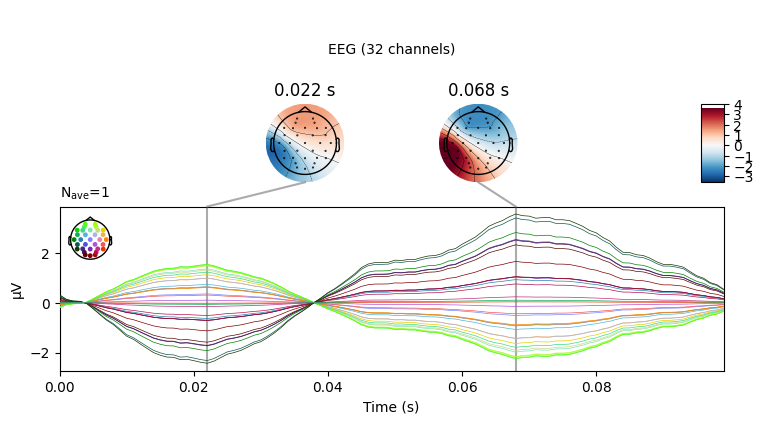

Using control points [0.00022079 0.00132155 0.07145801]


In [116]:
%matplotlib qt

stc_ = stc.copy()
stc_.data  = x_hat
evoked_ = mne.EvokedArray(leadfield @ x_hat, info)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)

brain.add_text(0.1, 0.9, "L1L2 MCE", 'title',
               font_size=14)

evoked_.plot_joint()

# Evaluate

In [202]:
stc_ = stc.copy()
stc_.data[:, 0] = x_best / abs(x_best).max()
stc_.plot(**pp, brain_kwargs=dict(title="S-FISTA"))

Using control points [0.0048464  0.0318313  0.61397084]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.31341884 0.40073647 0.86956696]


# MXNE

In [ ]:
noise_cov = mne.make_ad_hoc_cov(evoked.info)
evoked.set_eeg_reference("average", projection=True)
stc_mxne = mne.inverse_sparse.mixed_norm(evoked, fwd, noise_cov, alpha='sure', 
        loose=0, depth=0.8, maxit=3000, tol=0.0001, active_set_size=10, 
        debias=True, time_pca=True, weights=None, weights_min=0.0, solver='auto', 
        n_mxne_iter=1, return_residual=False, return_as_dipoles=False, 
        dgap_freq=10, rank=None, pick_ori=None, sure_alpha_grid='auto', 
        random_state=None, verbose=None)
stc_mxne.data /= abs(stc_mxne.data).max()
stc_mxne.plot(**pp, brain_kwargs=dict(title="MXNE"))

In [ ]:
stc_mxne.data.shape

In [ ]:
from scipy.stats import pearsonr
corr = lambda x, y: pearsonr(x, y)[0]
print(corr(stc.data.flatten(), stc_mxne.data.flatten()))
print(corr(stc.data.flatten(), stc_.data.flatten()))

In [ ]:
noise_cov = mne.make_ad_hoc_cov(evoked.info)
evoked.set_eeg_reference("average", projection=True)
stc_rap = mne.beamformer.rap_music(evoked, fwd, noise_cov, n_dipoles=5, return_residual=False, verbose=None)


In [ ]:
mne.inverse_sparse.make_stc_from_dipoles(stc_rap, fwd["src"]).plot(**pp)

In [ ]:
np.any(np.diff(fwd["src"][1]["vertno"])<0)

In [ ]:
fwd